# 영화 리뷰를 사용한 텍스트 분류
https://www.tensorflow.org/tutorials/keras/text_classification?hl=ko

In [1]:
import tensorflow as tf 
from tensorflow import keras 

import numpy as np 

print(tf.__version__)

2.5.0-dev20201230


- IMDB 데이터셋은 텐서플로와 함께 제공됩니다. 
- 리뷰(단어의 시퀀스(sequence))는 미리 전처리해서 정수 시퀀스로 변환되어 있습니다. 

In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# 훈련 데이터에서 가장 많이 등장하는 상위 10,000개의 단어 선택 (데이터 크기 유지하기 위함)

17465344/17464789 [==============================] - 2s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/wonji/.pyenv/versions/3.7.7/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/wonji/.pyenv/versions/3.7.7/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprec

In [3]:
print(len(train_data), len(train_labels))

25000 25000


In [5]:
print(train_data[0]) # 각 정수는 어휘 사전에 있는 특정 단어를 의미합니다.

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [8]:
print(len(train_data[0]), len(train_data[1])) # 매 리뷰는 다른 개수의 어휘를 가짐

218 189


In [9]:
train_labels[0]

1

In [10]:
# 데이터의 정수는 어떤 어휘에 해당하는가? 맵핑 
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [12]:
# 사전 정의된 
word_index = {k:(v+3) for k, v in word_index.items()} # 임의로 더 해도 되는 것인가..? 어차피 value <=3인 경우는 없는데...?

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

In [13]:
reverse_word_index = dict([(v, k) for (k, v) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [15]:
decode_review(train_data[1])

"<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

리뷰(정수 배열)는 신경망에 주입하기 전에 "텐서"로 변환되어야 함

- 원-핫 인코딩(one-hot encoding): 정수 배열을 0과 1로 이루어진 벡터로 변환합니다. 예를 들어 배열 [3, 5]을 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000차원 벡터로 변환할 수 있습니다. 그다음 실수 벡터 데이터를 다룰 수 있는 층(Dense 층)을 신경망의 첫 번째 층으로 사용합니다. 이 방법은 num_words * num_reviews 크기의 행렬이 필요하기 때문에 메모리를 많이 사용합니다.

- 정수 배열의 길이가 모두 같도록 패딩(padding)을 추가해 max_length * num_reviews 크기의 정수 텐서를 만듭니다. 이런 형태의 텐서를 다룰 수 있는 임베딩(embedding) 층을 신경망의 첫 번째 층으로 사용할 수 있습니다.

In [16]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, value=word_index["<PAD>"], padding='post', maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data, value=word_index["<PAD>"], padding='post', maxlen=256)
# 256보다 큰 데이터 없다는 가정 

In [17]:
print(len(train_data[0]), len(train_data[1])) # 매 리뷰는 같은 크기로 변환됨

256 256


In [18]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

신경망은 층(layer)을 쌓아서 만듭니다. 이 구조에서는 두 가지를 결정해야 합니다:

- 모델에서 얼마나 많은 층을 사용할 것인가?
- 각 층에서 얼마나 많은 은닉 유닛(hidden unit)을 사용할 것인가?

In [19]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,))) 
# 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이 벡터는 모델이 훈련되면서 학습됩니다. 
# 이 벡터는 출력 배열에 새로운 차원으로 추가됩니다. 최종 차원은 (batch, sequence, embedding)이 됩니다.
model.add(keras.layers.GlobalAveragePooling1D())
# sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
model.add(keras.layers.Dense(16, activation='relu'))
# 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층
model.add(keras.layers.Dense(1, activation='sigmoid'))
# 하나의 출력 노드를 가진 완전 연결(fully-connected) 층 -> 0~1 사이의 실수 출력 (확률 또는 신뢰도)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### 은닉 유닛 (hidden unit)
- 위 모델에는 입력과 출력 사이에 두 개의 중간 또는 "은닉" 층이 있습니다. 
- 은닉 유닛의 개수는 층이 가진 표현 공간(representational space)의 차원이 됩니다. (내부 표현을 학습할 때 허용되는 네트워크 자유도의 양)

- 모델에 많은 은닉 유닛(고차원의 표현 공간)과 층이 있다면 네트워크는 더 복잡한 표현을 학습할 수 있습니다. 하지만 네트워크의 계산 비용이 많이 들고 원치않는 패턴을 학습할 수도 있습니다 - 과대적합(overfitting) 가능성

### 손실 함수(loss function)와 옵티마이저(optimizer)
- 이 예제는 이진 분류 문제이고(출력층 유닛 = 1개) 모델이 확률을 출력하므로(sigmoid 활성화 함수 사용), binary_crossentropy 손실 함수를 사용

- mean_squared_error 등 다른 손실 함수도 가능하나, 일반적으로 binary_crossentropy가 확률을 다루는데 적합합니다. 이 함수는 확률 분포 간의 거리를 측정합니다. 여기에서는 정답인 타깃 분포와 예측 분포 사이의 거리입니다.

- 나중에 회귀(regression) 문제(예를 들어 주택 가격을 예측하는 문제)에 대해 살펴 볼 때 평균 제곱 오차(mean squared error) 손실 함수를 어떻게 사용하는지 알아 보겠습니다.



In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 검증세트 (validation set)
- 원본 훈련 데이터에서 10,000개의 샘플을 떼어내어 검증 세트(validation set)를 만들겠습니다.
- 왜 테스트 세트를 사용하지 않을까요? 훈련 데이터만을 사용하여 모델을 개발하고 튜닝하는 것이 목표입니다. 
- 그다음 테스트 세트를 사용해서 딱 한 번만 정확도를 평가합니다.

In [22]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [23]:
history = model.fit(partial_x_train, partial_y_train, 
                    epochs=40, batch_size=512, # 512개 샘플로 이뤄진 미니배치에서 40번의 에포크 동안 훈련 (모든 샘플에 대해 40번 반복)
                    validation_data=(x_val, y_val), verbose=1) # 훈련하는 동안 모델 손실과 정확도를 validation set을 통해 확인
# History 객체: 여기에는 훈련하는 동안 일어난 모든 정보가 담긴 딕셔너리(dictionary)가 들어 있습니다:

Epoch 1/40
30/30 [==============================] - 1s 13ms/step - loss: 0.6929 - accuracy: 0.5057 - val_loss: 0.6919 - val_accuracy: 0.4984
Epoch 2/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.5118 - val_loss: 0.6880 - val_accuracy: 0.5865
Epoch 3/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6850 - accuracy: 0.5957 - val_loss: 0.6784 - val_accuracy: 0.6947
Epoch 4/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6723 - accuracy: 0.6966 - val_loss: 0.6610 - val_accuracy: 0.7322
Epoch 5/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6503 - accuracy: 0.7518 - val_loss: 0.6340 - val_accuracy: 0.7722
Epoch 6/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6180 - accuracy: 0.7914 - val_loss: 0.5983 - val_accuracy: 0.7942
Epoch 7/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5762 - accuracy: 0.8113 - val_loss: 0.5562 - val_accuracy: 0.8120
Epoch 8/40
30/30 [=

In [24]:
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

782/782 - 0s - loss: 0.3222 - accuracy: 0.8734
[0.32219648361206055, 0.8733599781990051]


In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

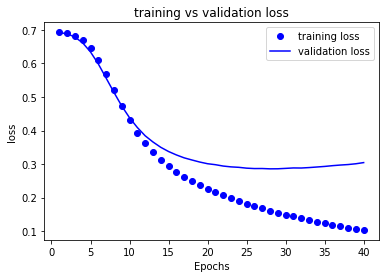

In [30]:
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')

plt.title('training vs validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

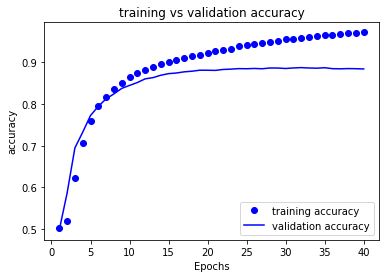

In [31]:
plt.clf() # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')

plt.title('training vs validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()